In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

tf.enable_eager_execution()
tf.set_random_seed(231)
print(tf.__version__)

import time
import math
from matplotlib import pyplot as plt

/Documents/venv3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
hparams = tf.contrib.training.HParams(
    batch_size=100,
    in_seq_len=61,
    input_dim=5,
    out_seq_len=61,
    output_dim=1,
    num_layers=2,
    neurons_unit=5,
    learning_rate = 0.001,
    lr_decay = 0.99,
    lambd = 1e-6,
    datagen = 'sin',
    logs_path = '/tmp/tensorflow_logs')

### Define Data Generator

In [367]:
# Load production dataset
if hparams.datagen == 'prodn':
    prodn = pd.read_pickle('../full_6d.pkl').values
    dataset = np.nan_to_num(prodn)[2:1002]
    mask = np.isfinite(prodn)[2:1002]
    #dataset = np.vstack((np.nan_to_num(prodn)[:5000,:500], np.nan_to_num(prodn)[:5000,30:530]))
    #mask = np.vstack((np.isfinite(prodn)[:5000,:500], np.isfinite(prodn)[:5000,30:530]))

# Create synthetic sine wave data
if hparams.datagen == 'sin':
    dataset = np.zeros((10 * hparams.batch_size, 10 * hparams.in_seq_len))
    dataset[1:,0] = np.random.randn(10 * hparams.batch_size-1)
    for i in range(dataset.shape[1] - 1):
        dataset[:,i+1] = dataset[:,i] + 2 * np.pi / hparams.in_seq_len
    dataset = np.sin(dataset) + 1
    mask = np.ones_like(dataset)

# Reshape data
in_len, out_len = hparams.in_seq_len, hparams.out_seq_len
end_pos = in_len * (hparams.input_dim - 1) + 1

# x.shape = (n_obs, in_seq_len, input_dim)
x = np.array([dataset[:,pos:pos+in_len] for pos in range(0,end_pos,hparams.in_seq_len)])
x = np.rollaxis(x, 0, 3) / np.max(dataset)
x = x[:,:,:,np.newaxis]

y =   dataset[:,end_pos+in_len:end_pos+in_len+out_len, np.newaxis] / np.max(dataset)
y_mask = mask[:,end_pos+in_len:end_pos+in_len+out_len, np.newaxis]

del(dataset, mask)
print(x.shape, y.shape, y_mask.shape)

(1000, 61, 5, 1) (1000, 61, 1) (1000, 61, 1)


In [368]:
dataset = tf.data.Dataset.from_tensor_slices((x.astype(np.float32), y.astype(np.float32), y_mask.astype(np.float32)))
dataset = dataset.batch(hparams.batch_size, drop_remainder=True)

### Define Model

In [198]:
class Attention(tf.keras.Model):
    def __init__(self, hidden_size, d_model, dropout=0.1):
        super(Attention, self).__init__()
        self.d_k = d_model

        self.q_dense_layer = tf.keras.layers.Dense(hidden_size, use_bias=False, name="q")
        self.k_dense_layer = tf.keras.layers.Dense(hidden_size, use_bias=False, name="k")
        self.v_dense_layer = tf.keras.layers.Dense(hidden_size, use_bias=False, name="v")
        
        self.out_dense_layer = tf.keras.layers.Dense(hidden_size, use_bias=False,
                                              name="output_transform")
        self.dropout = dropout
    
    def attention(self, query, key, value, mask=None, dropout=None):
        "Compute 'Scaled Dot Product Attention'"
        # Function accepts tensor of shape (m * d_p * d_k)
        assert len(query.shape) == 3
        m, d_p, d_k = query.shape
        
        scores = tf.matmul(query, key, transpose_b=True) / d_k.value ** 0.5
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        p_attn = tf.keras.layers.Softmax(axis = -1)(scores)
        if dropout is not None:
            p_attn = tf.keras.layers.Dropout(dropout)(p_attn)
        return tf.matmul(p_attn, value), p_attn
        
    def call(self, query, key, value, mask=None):
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
            # Note: Adjusted from mask = mask.unsqueeze(2)
        nbatches = query.shape[0]
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query = self.q_dense_layer(tf.squeeze(query))
        key   = self.k_dense_layer(tf.squeeze(key))
        value = self.v_dense_layer(tf.squeeze(value))

        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = self.attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        x = self.out_dense_layer(x)
        x = tf.keras.backend.expand_dims(x, axis=-1)
        return x

In [308]:
"""_, (inp, target, mask) = enumerate(dataset).__next__()
attn = Attention(7,5)
attn(inp, inp, inp)"""

TensorShape([Dimension(100), Dimension(61), Dimension(1)])

In [358]:
class AttentionModel(tf.keras.Model):
    def __init__(self, input_dim, period, output_dim, neurons_unit):
        super(AttentionModel, self).__init__()
        # store hparams
        self.input_dim    = input_dim
        self.output_dim   = output_dim
        self.period       = period
        self.neurons_unit = neurons_unit

        # define model
        self.attn_1  = Attention(self.neurons_unit, self.input_dim, dropout=None)
        self.flatten = tf.keras.layers.Flatten()
        self.fc_1    = tf.keras.layers.Dense(period, activation='relu',
                                            bias_initializer=tf.keras.initializers.Constant(value=0.5))

    def call(self, x, mask):
        x_a1 = self.attn_1(x, x, x)

        
        x_a2 = self.flatten(x_a1)
        x_a2 = self.fc_1(x_a2)
        
        return tf.keras.backend.expand_dims(x_a2, axis=-1) * mask

In [275]:
class AttentionModel(tf.keras.Model):
    def __init__(self, input_dim, period, output_dim, neurons_unit):
        super(AttentionModel, self).__init__()
        # store hparams
        self.input_dim    = input_dim
        self.output_dim   = output_dim
        self.period       = period
        self.neurons_unit = neurons_unit

        # define model
        self.attn_1  = Attention(neurons_unit, input_dim, dropout=None)

        self.conv1_1x1 = tf.keras.layers.Conv2D(32, (1,neurons_unit))
        self.conv1_3x1 = tf.keras.layers.Conv2D(32, (3,neurons_unit), padding='valid')
        self.conv1_5x1 = tf.keras.layers.Conv2D(32, (5,neurons_unit), padding='valid')

        self.conv1_cat = tf.keras.layers.Conv2D(32, (1,1), activation='relu')
        
        self.attn_2  = Attention(neurons_unit, neurons_unit, dropout=None)
        self.flatten = tf.keras.layers.Flatten()
        self.fc_1    = tf.keras.layers.Dense(period, activation='relu',
                                            bias_initializer=tf.keras.initializers.Constant(value=0.1))

    def call(self, x, mask):
        x = self.attn_1(x, x, x)
        
        l1_1 = self.conv1_1x1(x)
        l1_3 = tf.concat((x[:,-1:,:,:], x, x[:,:1,:,:]), axis=1)
        l1_3 = self.conv1_3x1(l1_3)
        l1_5 = tf.concat((x[:,-2:,:,:], x, x[:,:2,:,:]), axis=1)
        l1_5 = self.conv1_5x1(l1_5)
        
        l1_c = tf.concat((l1_1, l1_3, l1_5), axis=-1)
        l1_c = self.conv1_cat(l1_c)
        
        x_a2 = self.attn_2(l1_c, l1_c, l1_c)        
        x_a2 = self.flatten(x_a2)
        x_a2 = self.fc_1(x_a2)
        
        return tf.keras.backend.expand_dims(x_a2, axis=-1) * mask

In [ ]:
class Model(tf.keras.Model):
    def __init__(self, input_dim, period, output_dim):
        super(Model, self).__init__()
        # store hparams
        self.input_dim  = input_dim
        self.output_dim = output_dim
        self.period     = period

        """self.pad_3x1 = tf.keras.layers.ZeroPadding2D(((1,1),(0,0)))
        self.pad_5x1 = tf.keras.layers.ZeroPadding2D(((2,2),(0,0)))"""
        
        # define model
        self.conv1_1x1 = tf.keras.layers.Conv2D(32, (1,input_dim))
        self.conv1_3x1 = tf.keras.layers.Conv2D(32, (3,input_dim), padding='valid')
        self.conv1_5x1 = tf.keras.layers.Conv2D(32, (5,input_dim), padding='valid')

        self.conv1_cat = tf.keras.layers.Conv2D(32, (1,1), activation='relu')
        self.conv1_smooth1 = tf.keras.layers.Conv2D(32, (3,1), activation='relu')
        self.conv1_smooth2 = tf.keras.layers.Conv2D(16, (3,1), activation='relu')
        
        #self.fc_out = tf.keras.layers.Dense(period, activation='relu', bias_initializer='ones')
        self.fc_out = tf.keras.layers.Dense(period, activation='relu',
                                            bias_initializer=tf.keras.initializers.Constant(value=0.1))


    def call(self, x, mask):
        """l1_1 = self.conv1_1x1(x)
        l1_3 = self.pad_3x1(x)
        l1_3 = self.conv1_3x1(l1_3)
        l1_5 = self.pad_5x1(x)
        l1_5 = self.conv1_5x1(l1_5)"""

        l1_1 = self.conv1_1x1(x)
        l1_3 = tf.concat((x[:,-1:,:,:], x, x[:,:1,:,:]), axis=1)
        l1_3 = self.conv1_3x1(l1_3)
        l1_5 = tf.concat((x[:,-2:,:,:], x, x[:,:2,:,:]), axis=1)
        l1_5 = self.conv1_5x1(l1_5)
        
        l1_c = tf.concat((l1_1, l1_3, l1_5), axis=-1)
        l1_c = self.conv1_cat(l1_c)
        l1_s = self.conv1_smooth1(l1_c)
        l1_s = self.conv1_smooth2(l1_s)
        
        l1_fc = tf.keras.backend.batch_flatten(l1_s)
        l1_fc = self.fc_out(l1_fc)
        
        return tf.keras.backend.expand_dims(l1_fc, axis=-1) * mask

### Train Model

In [350]:
def loss_function(real, preds, variables, inputs, lambd = 1e-6):
    # Calculate OLS loss
    mse_loss = tf.losses.mean_squared_error(labels=real, predictions=preds)
    
    sum_mse_loss = tf.losses.mean_squared_error(tf.reduce_mean(real,  axis=(0,2)),
                                                tf.reduce_mean(preds, axis=(0,2)))
    
    smoothing_loss = tf.losses.mean_squared_error(labels=tf.concat((inputs[:,-1,-1,0:1], preds[:,:-1,0]), axis=-1),
                                                    predictions=preds[:,:,0])

    # Add L2 Regularisation
    l2_loss = 0
    for var in variables:
        l2_loss += lambd * tf.reduce_sum(var ** 2)

    #accuracy, loss = mse_loss, mse_loss + sum_mse_loss + l2_loss
    accuracy, loss = mse_loss, mse_loss + l2_loss
    #accuracy, loss = mse_loss, mse_loss + smoothing_loss + l2_loss
    #accuracy, loss = mse_loss, mse_loss
    
    return loss, accuracy

In [351]:
def train_model(model, optimizer, dataset, hparams, epochs = 10, verbose = True):

    training_run_start = time.time()
    stats = []

    for epoch in range(epochs):
        epoch_start = time.time()

        total_loss, total_accuracy = 0, 0

        for (batch, (inp, targ, mask)) in enumerate(dataset.shuffle(1000, seed=231)):

            with tf.GradientTape() as tape:
                predictions = model(inp, mask)
                loss, accuracy = loss_function(targ, predictions, model.variables, inp)

            # update statistics
            total_loss += loss
            total_accuracy += accuracy

            # update gradients
            variables = model.variables
            gradients = tape.gradient(loss, variables)
            optimizer.apply_gradients(zip(gradients, variables))

        if verbose:
            print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                                100 * total_loss / (batch+1), 100 * total_accuracy / (batch+1)))
            print('Time taken for 1 epoch {:.4f} sec\n'.format(time.time() - epoch_start))
        
        # apply learning rate decay
        optimizer._lr *= hparams.lr_decay
        stats.append([total_loss / (batch+1), total_accuracy / (batch+1), time.time() - epoch_start])
    
    return total_loss / (batch+1), total_accuracy / (batch+1), time.time() - training_run_start, np.array(stats)

Epoch 1 Loss 10.4977 Accuracy 10.4841
Time taken for 1 epoch 0.6727 sec

Epoch 2 Loss 5.7049 Accuracy 5.6912
Time taken for 1 epoch 0.6155 sec

Epoch 3 Loss 3.3265 Accuracy 3.3124
Time taken for 1 epoch 0.5832 sec

Epoch 4 Loss 2.2740 Accuracy 2.2595
Time taken for 1 epoch 0.5802 sec

Epoch 5 Loss 1.7871 Accuracy 1.7723
Time taken for 1 epoch 0.6815 sec

Epoch 6 Loss 1.5378 Accuracy 1.5227
Time taken for 1 epoch 0.6436 sec

Epoch 7 Loss 1.3935 Accuracy 1.3782
Time taken for 1 epoch 0.5855 sec

Epoch 8 Loss 1.3016 Accuracy 1.2861
Time taken for 1 epoch 0.5780 sec

Epoch 9 Loss 1.2394 Accuracy 1.2238
Time taken for 1 epoch 0.5840 sec

Epoch 10 Loss 1.1951 Accuracy 1.1793
Time taken for 1 epoch 0.5832 sec

Epoch 11 Loss 1.1623 Accuracy 1.1463
Time taken for 1 epoch 0.7523 sec

Epoch 12 Loss 1.1374 Accuracy 1.1213
Time taken for 1 epoch 0.5704 sec

Epoch 13 Loss 1.1179 Accuracy 1.1017
Time taken for 1 epoch 0.5588 sec

Epoch 14 Loss 1.1021 Accuracy 1.0858
Time taken for 1 epoch 0.5844 sec


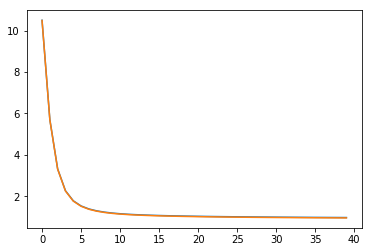

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
attention_387 (Attention)    multiple                  100       
_________________________________________________________________
flatten_2476 (Flatten)       multiple                  0         
_________________________________________________________________
dense_186 (Dense)            multiple                  18666     
Total params: 18,766
Trainable params: 18,766
Non-trainable params: 0
_________________________________________________________________


In [371]:
# Run a training batch
tf.set_random_seed(230) # Set seed

# Initialise model and optimiser
model = AttentionModel(hparams.input_dim, hparams.in_seq_len, hparams.output_dim, hparams.neurons_unit)
optimizer = tf.train.AdamOptimizer(learning_rate = hparams.learning_rate)

# Start training run
loss, accuracy, run_time, stats = train_model(model, optimizer, dataset, hparams, epochs=40, verbose=True)

# Display results
print('Loss {:.4f} Accuracy {:.4f} Time {:.4f}'.format(loss * 100, accuracy * 100, run_time))

plt.figure()
plt.plot(100*stats[:,:2])
plt.show()

model.summary()

In [ ]:
loss, accuracy, run_time, stats = train_model(model, optimizer, dataset, hparams, epochs=20, verbose=True)

### Make Predictions

(100, 61, 1) (100, 61, 1)


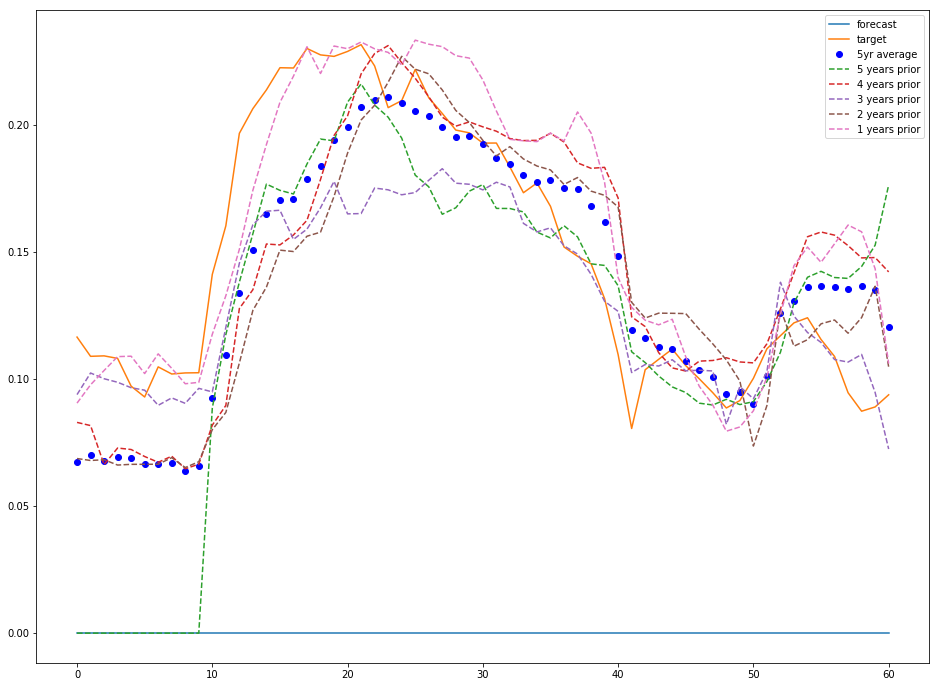

In [376]:
# empty string to store our results
TARGET_INDEX = 0
START_POINT = 0

_, (inp, target, mask) = enumerate(dataset).__next__()

forecast = model(inp, mask)

print(forecast.shape, target.shape)

# show target sequence
plt.figure(figsize=(16,12))
plt.plot(np.squeeze(forecast[TARGET_INDEX]), label='forecast')
plt.plot(np.squeeze(target[TARGET_INDEX]), label='target')
plt.plot(np.mean(inp, axis=2)[TARGET_INDEX], 'bo', label='5yr average')
for i in range(hparams.input_dim):
    plt.plot(np.array(inp)[TARGET_INDEX,:,i,0], '--', label='%i years prior' % (5-i))
plt.legend()
plt.show()

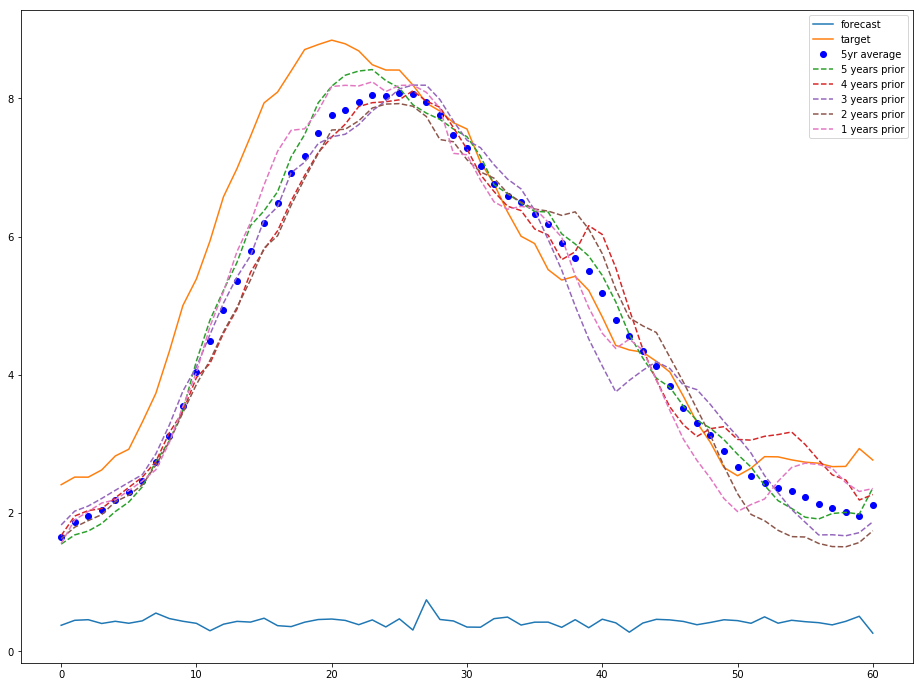

In [375]:
# show all sequences
plt.figure(figsize=(16,12))
plt.plot(np.sum(forecast, axis=(0,2)), label='forecast')
plt.plot(np.sum(target, axis=0), label='target')
plt.plot(np.sum(inp, axis=0).mean(axis=1), 'bo', label='5yr average')
for i in range(hparams.input_dim):
    plt.plot(np.sum(inp, axis=(0,3))[:,i], '--', label='%i years prior' % (5-i))

plt.legend()
plt.show()

In [181]:
l_ = np.sum((forecast - target) ** 2, axis=(1,2))
l_.argsort()

array([99, 73, 69, 26, 64, 63, 62, 60, 59, 43, 55, 54, 52, 51, 98, 47, 46,
       41, 45, 34, 21, 22, 75,  1,  2, 96, 95, 94, 93, 92, 20, 11, 10, 13,
       14, 83, 81, 79, 87, 44, 65, 82, 91, 66,  9, 49, 33, 74, 32, 50, 30,
       19, 80,  8, 58, 68, 38, 17, 57, 86, 67, 39, 42, 25,  7, 40, 24, 12,
       90, 15, 16, 89, 97,  5, 76, 77, 78,  4,  3, 88, 85, 18, 29,  0, 35,
       28, 48, 23,  6, 36, 31, 70, 27, 84, 56, 37, 71, 72, 53, 61])

### Test Hyperparameters

In [374]:
np.random.seed(231)
models, stats = [], []

lr    = np.log10(hparams.learning_rate)
nodes = hparams.neurons_unit

#for lr in np.random.uniform(-8, -1, 10):
#for nodes in np.floor(2 ** np.arange(3,9)):
for lr in range(-8, 0, 1):
    lr /= 2

    # Run a training batch
    tf.set_random_seed(231) # Set seed

    # Initialise model and optimiser
    model = AttentionModel(hparams.input_dim, hparams.in_seq_len, hparams.output_dim, int(nodes))
    optimizer = tf.train.AdamOptimizer(learning_rate = 10 ** lr)

    # Start training run
    loss, accuracy, run_time, stat = \
        train_model(model, optimizer, dataset, hparams, epochs = 20, verbose=False)
    print('Learning Rate {:.4f} Nodes {:.0f} Loss {:.4f} Accuracy {:.4f} Time {:.1f}'.format(
            lr, nodes, loss*100, accuracy * 100, run_time))
    
    models.append(model)
    stats.append(stat)

Learning Rate -4.0000 Nodes 5 Loss 2.7825 Accuracy 2.7688 Time 11.8
Learning Rate -3.5000 Nodes 5 Loss 1.3323 Accuracy 1.3182 Time 11.7
Learning Rate -3.0000 Nodes 5 Loss 1.0252 Accuracy 1.0105 Time 11.7
Learning Rate -2.5000 Nodes 5 Loss 0.9501 Accuracy 0.9340 Time 11.7
Learning Rate -2.0000 Nodes 5 Loss 0.9403 Accuracy 0.9194 Time 12.0
Learning Rate -1.5000 Nodes 5 Loss 0.9786 Accuracy 0.9192 Time 11.8
Learning Rate -1.0000 Nodes 5 Loss 1.2497 Accuracy 0.9191 Time 11.9
Learning Rate -0.5000 Nodes 5 Loss 2.5660 Accuracy 0.9191 Time 13.0
